## Running the calculation
**Running the code under Gouy-Chapman conditions takes approximately 19 minutes (iMac with 4 Ghz i7 processor).**

This is due to the Poisson-Boltzmann solver being run multiple times to minimise the difference between input and output mole fractions.

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.set_up_calculation import calculate_grid_offsets
from pyscses.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'dirichlet'
site_charges = False
systems = 'gouy-chapman'
core_models = False
site_models = 'continuum'

In [3]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -2.0e-8
grid_x_max = +2.0e-8
bulk_x_min = -2.0e-8
bulk_x_max = -1.0e-8

dielectric = 1

index = 111

b = 5e-9
c = 5e-9

temp = [773.15]

In [4]:
valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']
mole_fractions = [ [ 0.2, 0.2 ] ]
initial_guess = [ [ 0.2, 0.2 ] ]
mobilities = [1.0, 1.0]

In [5]:
data = '../input_data/example_data_2_one_seg_energies.txt'

The ```limits``` are the widths between the midpoint of the final site and an 'imaginary' site extending beyond the calculation unit. These are calculated to use in delta_x calculations where the width of each site is required to calculate volumes or densities. The ```laplacian_limits``` are the widths between the end sites.

```
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )
```

If the calculation is being run over a number of different conditions, the mole fractions are looped over. 

```
for m in mole_fractions:
```

If the calculation is being run over a number of different conditions, the temperatures are looped over.

```
for t in temp:
```

Next the different defect species are defined using the ```Defect_Species``` class. This collects and stores the information about each defect, the defect label, the defect valence and the defect mole fraction.

```
defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
```

The input data file and system information are passed into ```set_of_sites_from_input_data```, which formats and splits wach line of the input file to create ```Site``` objects for the individual sites, which are then grouped together into a ```SetOfSites``` object. 

```
all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
```

The code checks whether the model being used is continuum, if so, the sites are passed into ```form_continuum_sites``` which interpolates the defect segregation energies onto a regular grid.

```
if site_models == 'continuum':
    all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
```

ace charge models typically consider dopant ions as either mobile or immobile. If the dopant ions are considered immobile, the model follows a Mott-Schottky approximation. If the dopant ions are considered mobile, the model follows a Gouy-Chapman approximation. The code checks whether a Mott-Schottky or Gouy-Chapman approximation is being applied and fixes the mole fractions of the defects accordingly. 

```
if systems == 'mott-schottky':
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = True
if systems == 'gouy-chapman':
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = False
```

A grid is created using the ```Grid``` class. This includes the array of $x$ coordinates, b/c (the width and height of the cell used in the atomistic simulation) and the full set of sites ```all_sites```

```
grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
```

Following this, a Calculation object is created. This class contains the functions which calculate the space charge properties if the system.

```
c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, t, boundary_conditions, initial_guess )
```

Subgrids are created for each of the defect species.

```
c_o.form_subgrids( site_labels )
```

If the system follows Gouy-Chapman conditions, and periodic boundary conditions are being enforced, a mole fraction correction is required to ensure the output bulk mole fraction is equivalent to the input bulk mole fraction. This function runs the Poisson-Boltzmann calculation and minimises the difference between the target and output mole fractions. This is not required when running the calculation using Mott-Schottky conditions. 

```
c_o.mole_fraction_correction( m, system )
```

Next, the Poisson-Boltzmann equation is solved for the given system. The potential and charge density are calculated. This uses a function ```calculation``` which takes as arguments ``` grid, conv, temp, alpha and boundary_conditions ```. The ```calculation``` function creates numpy arrays the same length as the grid including zeros for the potential (```phi```) and the charge density (```rho```). 

 **Solving the Poisson-Boltzmann equation**

1. The invertible matrix $A$ is created from the distances between each of the points on the grid. Initially the full matrix is created using ```scipy.sparse.diags```  and is then converted into a sparse tridiagonal matrix using ```scipy.sparse.csc_matrix``` and the calculation follows the finite difference approximation method defined above. 
2. The convergence is initialised as 1 and while it is larger than ```conv``` defined in the notebook the calculation will iterate. 
3. Using the ```phi``` array of zeros, the charge density is calculated at each site. Using the calculated value for the charge density at each site $\Phi = A^{-1}b$ is solved using ```scipy.linalg.spsolve```. This returns ```predicted_phi``` at each site, which is damped using $\alpha$ to become the new ```phi``` array. The convergence is updated using $\frac{ \sum_i ( ( \Phi_{predicted} - \Phi )^2 )}{L_{grid.x}}$ where $L_{grid.x}$ is the length of the grid.

```
c_o.solve(system)
```

Using the calculated equilibrium electrostatic potentials at each site, the defect mole fractions can be calculated. 
```
c_o.mole_fractions()
```

The resistivity ratio can be calculated from the previously calculated defect concentrations. ```c_o.calculate_resistivity_ratio``` takes two arguments. Firstly, whether the space charge potential is positive or negative and secondly a limit for the value of the potential that the site must exceed to be considered as the space charge region.

```
c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
```

If the calculation is run over a number of temperatures, and the resistivity ratios stored in a list the activation energy can be calculates.

```
c_o.calculate_activation_energies( resistivity_ratios, temp )
```


In [6]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )

--- 1132.7030682563782 seconds ---


The space charge properties can then be plot, using ```matplotlib.pyplot```.

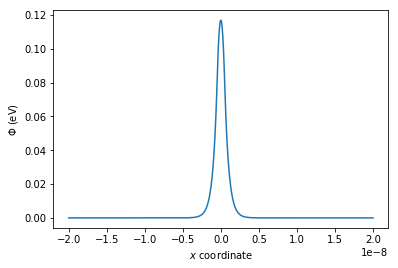

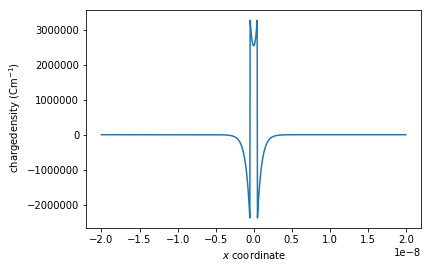

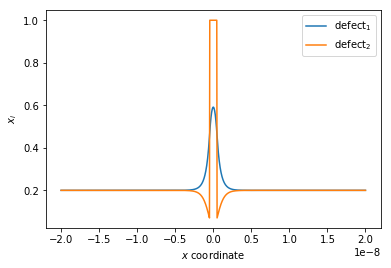

In [7]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()